In [69]:
import pandas as pd
import numpy as np

# load patient-level embeddings
embeddings = pd.read_csv('./autoencoder/latent_representations.csv')

# concatenate with the labels
labels = pd.read_csv('./data/msk_2024_mutations_filtered_10.csv')
# OS_STATUS	OS_MONTHS
labels = labels[['Patient', 'OS_STATUS', 'OS_MONTHS']]

# merge the embeddings with the labels
embeddings = pd.merge(embeddings, labels, on='Patient', how='left')
embeddings

,Patient,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,...,latent_120,latent_121,latent_122,latent_123,latent_124,latent_125,latent_126,latent_127,OS_STATUS,OS_MONTHS
0,P-0000015,-0.590739,-0.313533,0.740038,-0.108814,0.506573,0.316313,0.521639,0.951342,0.311245,...,0.021884,-0.489645,0.189106,0.853252,0.318574,-0.031326,-0.365652,-0.012958,1,13.906834
1,P-0000036,0.114577,-0.030874,0.636626,0.938581,0.374794,-0.210163,0.237881,0.742788,0.584691,...,0.708125,-0.894556,0.933675,0.585888,-0.142546,0.451756,-0.176748,0.132371,0,115.462887
2,P-0000041,-1.175931,-0.098091,-0.700459,0.690821,0.655146,0.166113,1.007227,1.806471,0.282799,...,0.864762,-1.149324,0.468622,0.153242,0.631505,-1.333249,0.457223,0.382173,1,13.610944
3,P-0000066,0.009071,-0.303804,0.610359,0.110105,0.427494,-0.257655,0.745908,0.812681,0.360530,...,0.087825,-0.653093,0.439370,0.548504,0.742342,0.451417,-0.377914,0.093220,0,76.635532
4,P-0000058,0.153450,-0.659450,0.902143,0.275213,0.457241,-0.442095,0.517159,0.786895,0.284671,...,0.203656,-0.850878,0.475477,0.577183,0.245579,0.529616,-0.196900,-0.071477,1,60.756098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23536,P-0087885,-0.403633,-1.247297,0.959955,-0.006110,0.586049,0.119307,0.277420,0.683563,0.147981,...,0.079349,-1.187323,0.250098,0.625340,-0.183191,-0.460916,-0.064143,-0.357638,0,5.753418
23537,P-0089690,-0.555292,-0.280726,-0.771121,0.775417,-0.787422,-1.194459,0.661972,1.143961,0.460920,...,0.186767,-0.549833,0.407689,0.229977,-0.380608,0.443806,-0.242635,0.100416,0,5.983555
23538,P-0089687,-0.780247,0.129021,1.327724,0.453454,1.464951,-0.095742,0.316777,0.752404,0.918951,...,0.092970,-0.016117,-0.220952,-0.171093,0.025271,-0.713560,0.490970,0.366070,0,0.493150
23539,P-0089676,0.154982,-0.440862,0.342084,-0.244663,0.152698,-0.780838,0.588502,1.125084,0.153062,...,-0.005459,-0.532622,0.461878,0.132174,0.226207,0.659491,0.214052,-0.075182,0,0.032877


In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index

df = embeddings.copy()

# Extract features (mutation presence) and target (survival months & status)
X = df.drop(columns=["OS_MONTHS", "OS_STATUS", "Patient"])  # Features: all columns except survival data and Patient ID
y_os = df["OS_MONTHS"].values  # Overall survival time
y_status = df["OS_STATUS"].values  # Overall survival status (0 = alive (censored), 1 = dead (event))

# Train-Validation-Test Split
X_train, X_temp, y_os_train, y_os_temp, y_status_train, y_status_temp = train_test_split(
    X, y_os, y_status, test_size=0.3, random_state=42
)
X_val, X_test, y_os_val, y_os_test, y_status_val, y_status_test = train_test_split(
    X_temp, y_os_temp, y_status_temp, test_size=0.5, random_state=42
)

# Convert to PyTorch tensors
X_train, y_os_train, y_status_train = map(torch.tensor, (X_train.values, y_os_train, y_status_train))
X_val, y_os_val, y_status_val = map(torch.tensor, (X_val.values, y_os_val, y_status_val))
X_test, y_os_test, y_status_test = map(torch.tensor, (X_test.values, y_os_test, y_status_test))

# Move to float tensors
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()
y_os_train, y_os_val, y_os_test = y_os_train.float(), y_os_val.float(), y_os_test.float()
y_status_train, y_status_val, y_status_test = y_status_train.float(), y_status_val.float(), y_status_test.float()

print(f"Train Size: {X_train.shape}, Validation Size: {X_val.shape}, Test Size: {X_test.shape}")


Train Size: torch.Size([16478, 128]), Validation Size: torch.Size([3531, 128]), Test Size: torch.Size([3532, 128])


In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# 0. MLP-Based Survival Model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1 = 256, hidden_dim2 = 256, dropout=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x.squeeze(-1)  # Ensure output is (batch,)
    
class SmallMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1 = 64, hidden_dim2 = 32, dropout=0.3):
        super(SmallMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x.squeeze(-1)  # Ensure output is (batch,)
    
# ---------------------------
# Define Transformer/Self-Attention Risk Predictor
# ---------------------------
class RiskPredictor(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=1):
        """
        A small transformer-based head for risk prediction.
        - Projects each latent feature (token) from scalar to d_model.
        - Adds a learned positional embedding.
        - Processes the sequence with a Transformer encoder.
        - Pools the sequence and outputs a risk score.
        """
        super(RiskPredictor, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        
        # Project each latent scalar (token) to a d_model vector.
        self.token_embedding = nn.Linear(1, d_model)
        # Learnable positional embedding for each token.
        self.pos_embedding = nn.Parameter(torch.randn(input_dim, d_model))
        
        # Transformer Encoder: using one or more layers.
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final linear layer that outputs a single risk score.
        self.fc = nn.Linear(d_model, 1)
        
    def forward(self, x):
        """
        x: tensor of shape (batch_size, input_dim)
        """
        batch_size, seq_len = x.shape
        # Reshape so that each latent dimension is treated as a token:
        # (batch_size, input_dim) -> (batch_size, input_dim, 1)
        x = x.unsqueeze(2)
        # Project each token to d_model:
        # shape becomes (batch_size, input_dim, d_model)
        x = self.token_embedding(x)
        # Add positional embeddings: (input_dim, d_model) is broadcasted over batch.
        x = x + self.pos_embedding.unsqueeze(0)
        # Transformer expects input of shape (sequence_length, batch_size, d_model)
        x = x.transpose(0, 1)  # now shape (input_dim, batch_size, d_model)
        # Pass through the Transformer encoder.
        x = self.transformer_encoder(x)
        # Pool over the sequence dimension (mean pooling)
        x = x.mean(dim=0)  # shape: (batch_size, d_model)
        # Output risk score:
        risk = self.fc(x)  # shape: (batch_size, 1)
        return risk.squeeze(1)  # shape: (batch_size)

# ---------------------------
# Self-Attention Risk Predictor
# ---------------------------
class SelfAttentionRiskPredictor(nn.Module):
    def __init__(self, input_dim=128, d_model=32):
        """
        Lightweight self-attention mechanism over the latent features.
        - Each of the 128 latent features (tokens) is first projected from 1 to d_model.
        - We then compute scaled dot-product attention over the tokens.
        - The attended representation is aggregated (mean-pooled) and fed into a linear layer to output a risk score.
        """
        super(SelfAttentionRiskPredictor, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        
        # Project each latent scalar (token) to d_model dimensions.
        self.token_proj = nn.Linear(1, d_model)
        
        # Define layers to compute query, key, value for self-attention.
        self.query = nn.Linear(d_model, d_model)
        self.key   = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        
        # Final layer for risk score.
        self.fc_out = nn.Linear(d_model, 1)
        self.scale = d_model ** 0.5

    def forward(self, x):
        """
        x: Tensor of shape (batch_size, 128)
        """
        batch_size = x.size(0)
        # Treat each of the 128 latent dimensions as a token.
        # Reshape to (batch_size, seq_len=128, token_dim=1)
        x = x.unsqueeze(-1)
        # Project tokens: (batch_size, 128, d_model)
        tokens = self.token_proj(x)
        # Compute Q, K, V
        Q = self.query(tokens)  # (batch_size, 128, d_model)
        K = self.key(tokens)    # (batch_size, 128, d_model)
        V = self.value(tokens)  # (batch_size, 128, d_model)
        # Compute scaled dot-product attention scores: (batch_size, 128, 128)
        att_scores = torch.bmm(Q, K.transpose(1, 2)) / self.scale
        att_weights = torch.softmax(att_scores, dim=-1)
        # Compute weighted sum: (batch_size, 128, d_model)
        att_output = torch.bmm(att_weights, V)
        # Aggregate the token representations (mean pooling)
        agg = att_output.mean(dim=1)  # (batch_size, d_model)
        # Compute risk score (scalar per patient)
        risk = self.fc_out(agg)  # (batch_size, 1)
        return risk.squeeze(1)   # (batch_size)

# test the model
# maximum 700
x_test = torch.randn(500, 128)  # 10 samples, 32 features
model = SelfAttentionRiskPredictor(input_dim=128, d_model=32)
# model = SmallMLP(input_dim=128, hidden_dim1=64, hidden_dim2=32, dropout=0.3)  # Use SmallMLP for testing
output = model(x_test)
print("Output shape:", output.shape)  # Should be (30000,)

Output shape: torch.Size([500])


In [72]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train, y_os_train, y_status_train = X_train.to(device), y_os_train.to(device), y_status_train.to(device)
X_val, y_os_val, y_status_val = X_val.to(device), y_os_val.to(device), y_status_val.to(device)
X_test, y_os_test, y_status_test = X_test.to(device), y_os_test.to(device), y_status_test.to(device)

# normalize the y_os_train, y_os_val, y_os_test using log1p
y_os_train = torch.log1p(y_os_train)
y_os_val = torch.log1p(y_os_val)
y_os_test = torch.log1p(y_os_test)

Using device: cuda


In [73]:
def cox_loss_vectorized(risk, time, event):
    """
    Vectorized Cox partial likelihood loss.
    
    risk: (batch,) tensor of predicted risk scores.
    time: (batch,) tensor of survival times (e.g., log-transformed).
    event: (batch,) tensor of event indicators (1 if event occurred, 0 if censored).
    """
    # Sort in descending order of time
    order = torch.argsort(time, descending=True)
    risk = risk[order]
    time = time[order]
    event = event[order]
    
    exp_risk = torch.exp(risk)
    # Cumulative sum over the risk set (for each sample i, sum exp(risk[j]) for j >= i)
    cum_sum = torch.cumsum(exp_risk, dim=0)
    diff = risk - torch.log(cum_sum + 1e-8)
    loss = -torch.sum(diff * event) / (torch.sum(event) + 1e-8)
    return loss

def c_index_ranking_loss_vectorized(risk, time, event, margin=0.0):
    """
    Optimized, vectorized pairwise ranking loss that approximates the c-index.
    
    risk: (batch,) predicted risk scores.
    time: (batch,) survival times.
    event: (batch,) event indicators.
    margin: margin for the loss (default=0.0).
    """
    # Compute pairwise differences: diff[i,j] = risk[j] - risk[i] - margin.
    diff = risk.unsqueeze(0) - risk.unsqueeze(1) - margin  # shape: (batch, batch)
    
    # Valid pair mask: valid if sample i had an event and time[i] < time[j]
    valid_mask = (time.unsqueeze(1) < time.unsqueeze(0)) & (event.unsqueeze(1) == 1)
    
    # Use softplus as a smooth approximation: log(1 + exp(diff))
    loss_matrix = F.softplus(diff)
    
    valid_loss = loss_matrix[valid_mask]
    count = valid_loss.numel()
    
    if count > 0:
        return valid_loss.sum() / count
    else:
        return torch.tensor(0.0, device=risk.device, requires_grad=True)
    
def hybrid_survival_loss(risk, time, event, alpha=0.5, margin=0.0):
    """
    Hybrid loss combining Cox partial likelihood and ranking loss.
    
    alpha: weight for the Cox loss (0 <= alpha <= 1).
        (1 - alpha) is the weight for the ranking loss.
    """
    loss_cox = cox_loss_vectorized(risk, time, event)
    loss_rank = c_index_ranking_loss_vectorized(risk, time, event, margin)

    # check scales
    # print(f"Loss Cox: {loss_cox.item()}, Loss Rank: {loss_rank.item()}")
    # print(f"Loss Cox Scale: {alpha * loss_cox.item()}, Loss Rank Scale: {(1 - alpha) * loss_rank.item()}")
    
    return alpha * loss_cox + (1 - alpha) * loss_rank

In [74]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for Survival Data
class SurvivalDataset(Dataset):
    def __init__(self, X, time, event):
        self.X = X
        self.time = time
        self.event = event
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.time[idx], self.event[idx]

batch_size = 1024  # Adjust based on your memory constraints

# Create dataset objects
train_dataset = SurvivalDataset(X_train, y_os_train, y_status_train)
val_dataset   = SurvivalDataset(X_val, y_os_val, y_status_val)
test_dataset  = SurvivalDataset(X_test, y_os_test, y_status_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# For validation and test we use full batches (since they are smaller)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
# ---------------------------


In [75]:
model_type = "MLP"  # Change to "MLP", "CNN", or "LSTM" as desired

# Assume X_train exists; if not, default to an example input dimension of 10.
input_dim = X_train.shape[1] if 'X_train' in globals() else 10

if model_type == "MLP":
    model = MLP(input_dim, hidden_dim1=128, hidden_dim2=64)
elif model_type == "SmallMLP":
    model = SmallMLP(input_dim, hidden_dim1=64, hidden_dim2=32)
elif model_type == "Transformer":
    model = RiskPredictor(input_dim=input_dim, d_model=32, nhead=4, num_layers=1)
elif model_type == "SA":
    model = SelfAttentionRiskPredictor(input_dim=input_dim, d_model=32)

print(model)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

MLP(
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
from lifelines.utils import concordance_index
from sklearn.metrics import roc_auc_score

num_epochs = 60

train_losses, val_losses, val_c_indices, val_aurocs = [], [], [], []

for epoch in range(num_epochs):
    # ---- Training Phase ----
    epoch_loss = 0.0
    # model.train()
    # for batch_X, batch_time, batch_event in train_loader:
    #     batch_X, batch_time, batch_event = batch_X.to(device), batch_time.to(device), batch_event.to(device)
    #     optimizer.zero_grad()
    #     risk = model(batch_X)
    #     # loss = hybrid_survival_loss(risk, batch_time, batch_event, alpha=0.5, margin=0.0)
    #     loss = c_index_ranking_loss_vectorized(risk, batch_time, batch_event, margin=0.0)
    #     loss.backward()
    #     optimizer.step()
    #     epoch_loss += loss.item() * batch_X.size(0)
    # epoch_loss /= len(train_dataset)
        
    model.train()
    optimizer.zero_grad()
    risk = model(X_train)
    # loss = hybrid_survival_loss(risk, y_os_train, y_status_train, alpha=0.5, margin=0.0)
    loss = cox_loss_vectorized(risk, y_os_train, y_status_train)
    loss.backward()
    optimizer.step()
    epoch_loss = loss.item()

    train_losses.append(epoch_loss)
    
    # ---- Validation Phase ----
    model.eval()
    with torch.no_grad():
        # We compute validation loss and predictions on the full validation set
        for val_X, val_time, val_event in val_loader:
            val_X, val_time, val_event = val_X.to(device), val_time.to(device), val_event.to(device)
            val_risk = model(val_X)
            val_loss = hybrid_survival_loss(val_risk, val_time, val_event)
            
            # Convert log-transformed times back to original scale for c-index
            val_risk_np = val_risk.cpu().numpy()
            val_time_np = val_time.cpu().numpy()
            val_event_np = val_event.cpu().numpy()
            val_time_orig = np.expm1(val_time_np)
            c_index = concordance_index(val_time_orig, -val_risk_np, val_event_np)
            try:
                auroc = roc_auc_score(val_event_np, val_risk_np)
            except Exception:
                auroc = np.nan
    
    val_losses.append(val_loss.item())
    val_c_indices.append(c_index)
    val_aurocs.append(auroc)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {epoch_loss:.4f}, Val Loss {val_loss.item():.4f}, "
            f"c-index {c_index:.4f}, AUROC {auroc:.4f}")

Epoch 10/60: Train Loss 8.9546, Val Loss 4.1137, c-index 0.5962, AUROC 0.5912
Epoch 20/60: Train Loss 8.9484, Val Loss 4.1137, c-index 0.5984, AUROC 0.5915
Epoch 30/60: Train Loss 8.9370, Val Loss 4.1159, c-index 0.5990, AUROC 0.5929
Epoch 40/60: Train Loss 8.9269, Val Loss 4.1227, c-index 0.5961, AUROC 0.5898
Epoch 50/60: Train Loss 8.9273, Val Loss 4.1243, c-index 0.5948, AUROC 0.5895
Epoch 60/60: Train Loss 8.9144, Val Loss 4.1252, c-index 0.5941, AUROC 0.5886


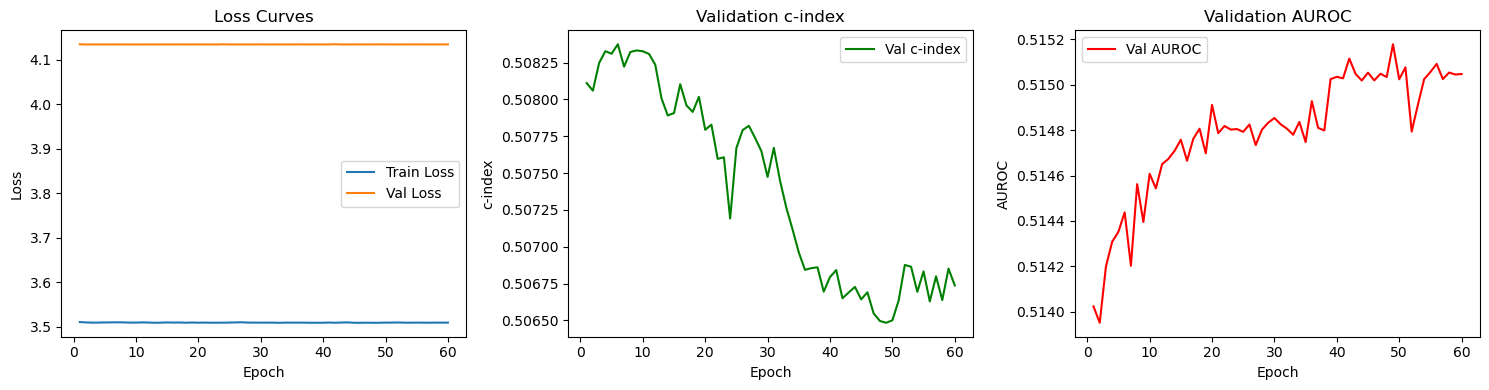

In [67]:
epochs_arr = np.arange(1, num_epochs + 1)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs_arr, train_losses, label="Train Loss")
plt.plot(epochs_arr, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_arr, val_c_indices, label="Val c-index", color='green')
plt.xlabel("Epoch")
plt.ylabel("c-index")
plt.title("Validation c-index")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_arr, val_aurocs, label="Val AUROC", color='red')
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.title("Validation AUROC")
plt.legend()

plt.tight_layout()
# save the plot
plt.savefig('./fig/survival_model_subtype_ae_mlp.png')

plt.show()